<a href="https://colab.research.google.com/github/kratiagrawal100/SMAI_Team_30/blob/main/Domain_Adaptation_Anuja_lambda_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>Domain Adaptation</h1></center>

<center><h2><a href="https://arthurdouillard.com/deepcourse/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

If you find a mistake, or know how to improve this notebook, please open an issue [here](https://github.com/arthurdouillard/deepcourse/issues).

We will implement the paper **Unsupervised Domain Adaptation by Backpropagation** in this session. I strongly advise to read this paper, it's a major one!

https://arxiv.org/abs/1409.7495

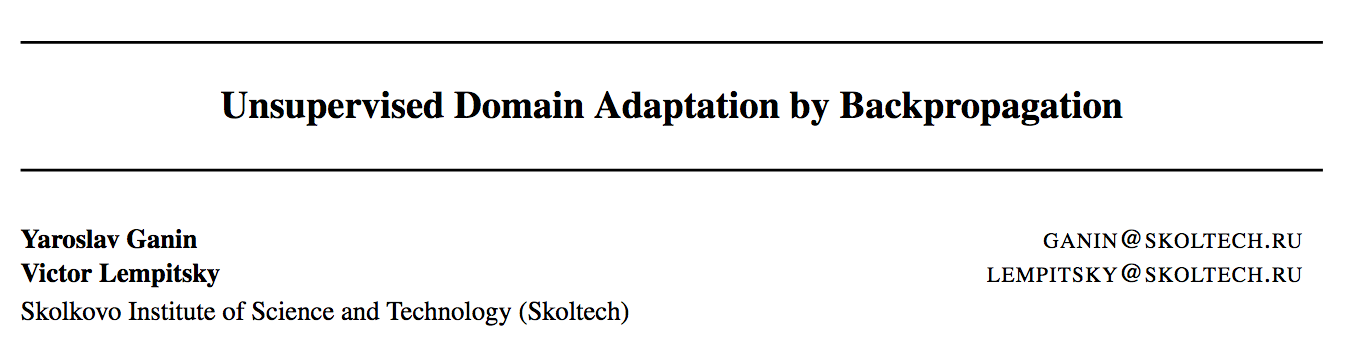

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

We are going to do a **domain adaptation** from a source dataset (MNIST) towards a target dataset (MNIST-M).

First, we need to create the target dataset:

In [3]:
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/da/mnistm.py
from mnistm import create_mnistm

create_mnistm()

--2023-05-03 16:17:03--  https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/da/mnistm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2659 (2.6K) [text/plain]
Saving to: ‘mnistm.py’

mnistm.py           100%[===================>]   2.60K  --.-KB/s    in 0s      

2023-05-03 16:17:03 (47.8 MB/s) - ‘mnistm.py’ saved [2659/2659]

Creating MNIST-M... That may takes a minute
Loading BSR training images


100%|██████████| 9912422/9912422 [00:00<00:00, 70189997.22it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 85850952.39it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25215448.16it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20266519.97it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/content/mnistm.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bg_img = rand.choice(background_data)


Building train set...
Processing example 0
Processing example 10000
Processing example 20000
Processing example 30000
Processing example 40000
Processing example 50000
Building test set...
Processing example 0
Done!


In [4]:
# Execute this cell to see the solution, but try to do it by yourself before!
# !wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/siamese/backbone.py
# %pycat backbone.py

Then, let's load the MNIST dataset and compute its (train!) mean and standard deviation.

We will use those values to **standardize** both MNIST and MNIST-M.

In [5]:
mnist_pixels = torchvision.datasets.MNIST('.', train=True, download=True).data / 255
mean = mnist_pixels.mean().item()
std = mnist_pixels.std().item()

print(f"Mean {mean} and Std {std}")
mean = torch.tensor([mean, mean, mean])
std = torch.tensor([std, std, std])

Mean 0.13066047430038452 and Std 0.30810782313346863


Create the loaders for MNIST...

In [6]:
transform = transforms.Compose([
  transforms.ToTensor(),
  lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
  transforms.Normalize(mean, std)
])

mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])
mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform)

source_train_loader = DataLoader(mnist_train, batch_size=128)
source_test_loader = DataLoader(mnist_test, batch_size=128)

In [7]:
len(mnist_train)
len(mnist_test)

10000

In [8]:
dataiter = iter(source_train_loader)
images, labels = next(dataiter)
print(images.shape)

torch.Size([128, 3, 28, 28])


... and visualize!

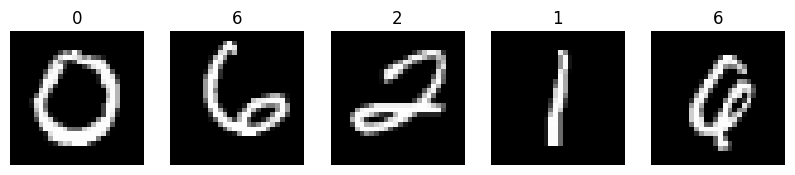

In [9]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnist_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8), cmap='gray')
  plt.title(y)

Likewise, for MNIST-M. We create a simple `Dataset` in order to load the dataset that was serialized as a pickle:

In [10]:
with open('mnistm_data.pkl', 'rb') as f:
  mnist_m = pickle.load(f)

class MNISTM(torch.utils.data.Dataset):
  def __init__(self, x, y, transform):
    self.x, self.y = x, y
    self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    x = self.transform(x)

    return x, y

mnistm_train = MNISTM(mnist_m["x_train"], mnist_m["y_train"], transform)
mnistm_train,mnistm_val=torch.utils.data.random_split(mnistm_train, [50000, 10000])
mnistm_test = MNISTM(mnist_m["x_test"], mnist_m["y_test"], transform)

target_train_loader = DataLoader(mnistm_train, batch_size=128)
target_test_loader = DataLoader(mnistm_test, batch_size=128)

In [11]:
len(mnistm_train)

50000

And we also visualize it. Remember to always visualize your data before training a model on it. You may realize that the dataset is ill-formated, in its pixels or targets, and have to do more data preparation beforehand.

Noice that **MNIST-M** is extremely similar to MNIST. The only difference is that the former has colors and textures, and is thus a RGB image. Because MNIST is in grayscale, we have duplicated thrice its channels axis.

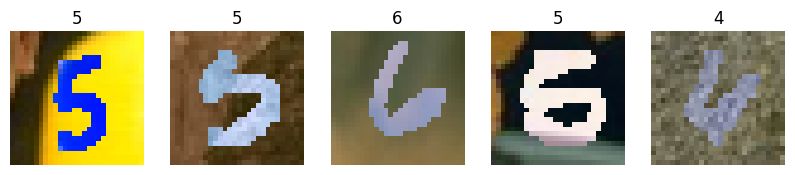

In [12]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnistm_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8))
  plt.title(y)

In [13]:
dataiter = iter(target_train_loader)
images, labels = next(dataiter)
print(images.shape)

torch.Size([128, 3, 28, 28])


Now, let's implement this basic network, whose figure is extracted from the paper. Conceive your model so that convolutions do not reduce the spatial dimensions:

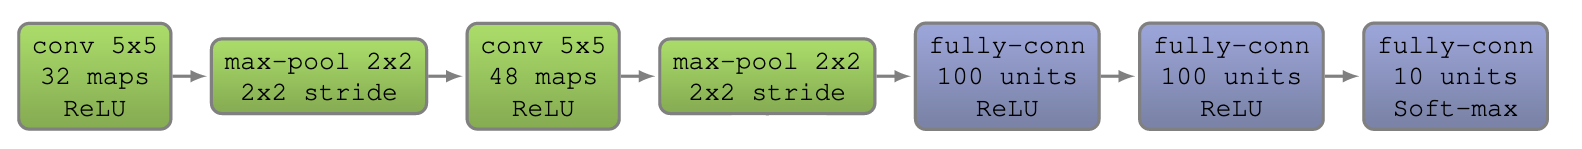

In [14]:
# class NaiveNet(nn.Module):
#   def __init__(self):
#     super().__init__()  # Important, otherwise will throw an error

#     self.cnn = None # TODO

#     self.classif = None # TODO

#   def forward(self, x):
#     # TODO
#     return x

class NaiveNet(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=5),  # 32x24x24
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),  # 32x12x12
        nn.Conv2d(32, 48, kernel_size=5),  # 48x8x8
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),  # 48x4x4
    )

    self.classif = nn.Sequential(
        nn.Linear(4 * 4 * 48, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 10)
    )

  def forward(self, x):
    batch_size = len(x)

    x = self.cnn(x)
    x = x.view(batch_size, -1)
    return self.classif(x)


NaiveNet()(torch.randn(2, 3, 28, 28)).shape

torch.Size([2, 10])

In [15]:
# Execute this cell to see the solution, but try to do it by yourself before!
# !wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/da/naive.py
# %pycat naive.py

In [16]:
def eval_model(net, loader):
  net.eval()

  acc, loss = 0, 0.
  c = 0
  for x, y in loader:
    c += len(x)

    with torch.no_grad():
      logits = net(x.cuda()).cpu()

    loss += F.cross_entropy(logits, y).item()
    acc += (logits.argmax(dim=1) == y).sum().item()

  return round(100 * acc / c, 2), round(loss / len(loader), 5)

Let's train our naive model, but only the source (MNIST) dataset. We will evaluate its performance on the target (MNIST-M) dataset afterwards.

Notice that we use a **learning rate scheduler**. We are updating the learning rate after each epoch according to a function defined with a *lambda* following the paper specification. 

We set the initial learning rate to 1.0 because `LambdaLR` defines a *multiplicative factor* of the base learning rate.

It's often useful to reduce likewise the learning rate during training, to facilitate convergence once the model has found a good local minima (we rarely find the global).

In [17]:
epochs = 10

naive_net = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: mu0 / (1 + alpha * e / epochs) ** beta
)

for epoch in range(epochs):
  train_loss = 0.

  for x, y in source_train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = naive_net(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  print(f'Epoch {epoch}, train loss: {round(train_loss / len(source_train_loader), 5)}')
  scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr']}")

test_acc, test_loss = eval_model(naive_net, source_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Epoch 0, train loss: 0.37797
	Learning rate = 0.005946035575013606
Epoch 1, train loss: 0.06472
	Learning rate = 0.004386913376508308
Epoch 2, train loss: 0.04616
	Learning rate = 0.0035355339059327372
Epoch 3, train loss: 0.03661
	Learning rate = 0.002990697562442441
Epoch 4, train loss: 0.03072
	Learning rate = 0.0026084743001221454
Epoch 5, train loss: 0.02642
	Learning rate = 0.002323680802425408
Epoch 6, train loss: 0.02323
	Learning rate = 0.0021022410381342864
Epoch 7, train loss: 0.0208
	Learning rate = 0.0019245008972987524
Epoch 8, train loss: 0.01892
	Learning rate = 0.0017782794100389228
Epoch 9, train loss: 0.01741
	Learning rate = 0.0016556002607617019
Test loss: 0.02821, test acc: 99.04


Performance onn less than 10 epochs are great on MNIST, more than 99% accuracy! But this dataset is quite easy.

Now, the real question is: can our model generalize on the slightly different domain of MNIST-M?

In [18]:
test_acc, test_loss = eval_model(naive_net, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 1.37406, test acc: 57.11


No... You should have an accuracy of 53 to 57%, far less than the 99% we had.

We are going to implement **DANN**, the **Domain Adverserial Neural Network**. The key part of this network is its domain prediction branch and its **gradient reversal layer** (GRL).

The GRL will reverse the gradient between the domain classifier (in pink) and the features extractor (in green).

What does it mean intuitively? The gradient of the domain classifier should help to better classify the domain. Therefore if we reverse it before the end of the features extractor, we will force this CNN to do the opposite: to make the features as agnostic as possible from the domain. Which would mean that the features of MNIST and MNIST-M will be similar and only the digit info will be kept.

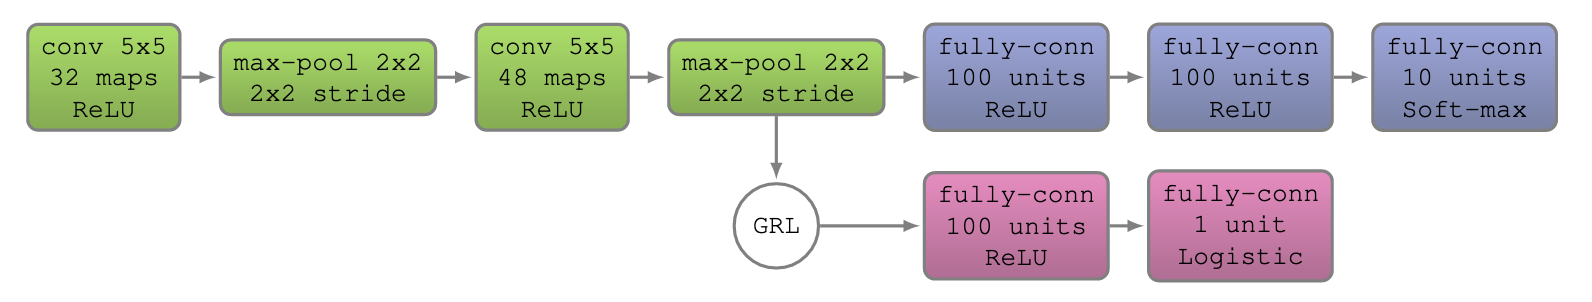

To code a custom backward in PyTorch, you need to define a `torch.autograd.Function`.

The forward is easy, we do nothing except storing a factor that we will need in the backward pass.

In the backward pass we need to return as much gradients as there are inputs (here two). Because the factor is not something to be optimized, we return `None`.

Now, given the factor (which is defaulted to -1, aka "reverse"), define the modified gradient:



In [19]:
# class GradientReversal(torch.autograd.Function):
#   @staticmethod
#   def forward(ctx, x, factor=-1):
#     ctx.save_for_backward(torch.tensor(factor))
#     return x

#   @staticmethod
#   def backward(ctx, grad):
#     factor, = ctx.saved_tensors

#     reversed_grad = # TODO

#     return reversed_grad, None

In [20]:
# Execute this cell to see the solution, but try to do it by yourself before!
# !wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/da/grl.py
# %pycat grl.py

class GradientReversal(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, factor=-1):
    ctx.save_for_backward(torch.tensor(factor))
    return x

  @staticmethod
  def backward(ctx, grad):
    factor, = ctx.saved_tensors

    return factor * grad, None


In [21]:
x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = x * y
o.backward()
print(x.grad.item())

x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = GradientReversal.apply(x * y, -1)
o.backward()
print(x.grad.item())

1337.0
-1337.0


To use a PyTorch's `Function`, call its apply 

Now, code the DANN. You can re-use parts of the code you wrote for the naive model.

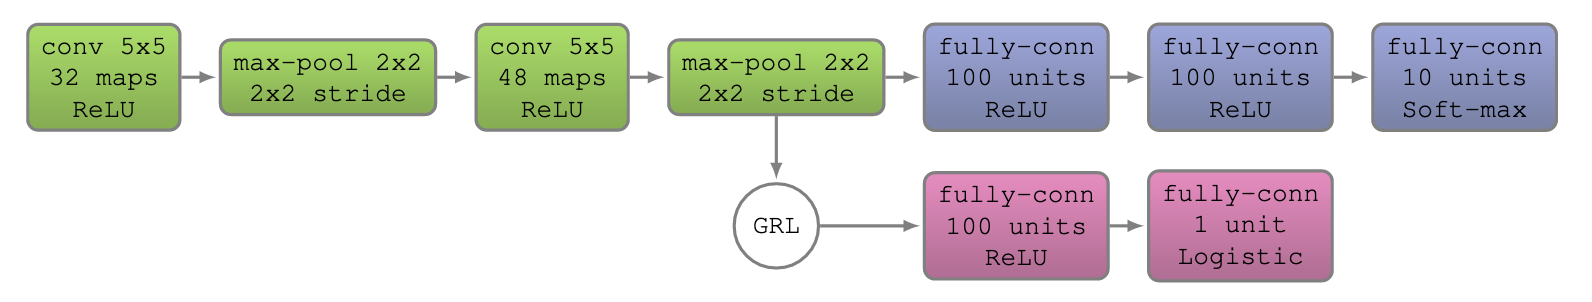

In [22]:
# class DANN(nn.Module):
#   def __init__(self):
#     super().__init__()  # Important, otherwise will throw an error

#     self.cnn = # TODO

#     self.classif = # TODO

#     self.domain = # TODO

#   def forward(self, x, factor=1):
#     # TODO

#     return class_pred, domain_pred


In [23]:
# Execute this cell to see the solution, but try to do it by yourself before!
# !wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/da/dann.py
# %pycat dann.py

class DANN(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=5),  # 32x28x28
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),  # 32x14x14
        nn.Conv2d(32, 48, kernel_size=5),  # 48x14x14
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),  # 48x7x7
    )

    self.classif = nn.Sequential(
        nn.Linear(4 * 4 * 48, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 10)
    )

    self.domain = nn.Sequential(
        nn.Linear(4 * 4 * 48, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 1)
    )

    self.grl = GradientReversal.apply

  def forward(self, x, factor=1):
    batch_size = len(x)

    x = self.cnn(x)
    x = x.view(batch_size, -1)

    class_pred = self.classif(x)
    domain_pred = self.domain(self.grl(x, -1 * factor))

    return class_pred, domain_pred


In [24]:
def eval_dann(net, loader, source=True):
  net.eval()

  c_acc, d_acc, cls_loss, d_loss = 0, 0, 0., 0.
  c = 0
  for x, y in loader:
    x = x.cuda()
    if source:
      d = torch.ones(len(x))
    else:
      d = torch.zeros(len(x))

    c += len(x)

    with torch.no_grad():
      cls_logits, domain_logits = net(x.cuda())
      cls_logits, domain_logits = cls_logits.cpu(), domain_logits.cpu()

    cls_loss += F.cross_entropy(cls_logits, y).item()
    d_loss += F.binary_cross_entropy_with_logits(domain_logits[:, 0], d).item()

    c_acc += (cls_logits.argmax(dim=1) == y).sum().item()
    d_acc += ((domain_logits[:, 0] > 0.5).float() == d).sum().item()

  return round(100 * c_acc / c, 2), round(100 * d_acc / c, 2), round(cls_loss / len(loader), 5), round(d_loss / len(loader), 5)

In [25]:
source_train_loader = DataLoader(mnist_train, batch_size=64)
target_train_loader = DataLoader(mnistm_train, batch_size=64)

len(source_train_loader), len(target_train_loader)

(782, 782)

For the GRL, using directly a factor -1 will results in very bad performance. Therefore we are going to grow the factor gradually during training (deep learning is an art!).

Here is a plot of the function we will use (note that it is a modified version from the paper):

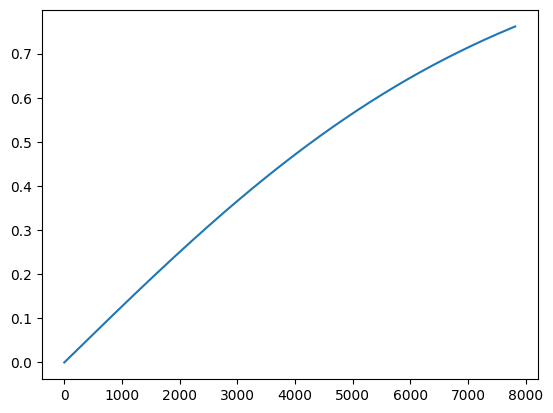

In [26]:
nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / nb_iters))
y = [lmbd(i) for i in x]

plt.plot(x, y)


In [27]:
# data,label=next(iter(source_train_loader))
# print(data.shape)

Let's train our DANN. The GRL factor will be updated after each batch.

Remember that we are not allowed to use the labels of MNIST-M as we assume this dataset is **unlabeled**.

In [28]:
epochs = 20

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=0.001, momentum=0.9)

# mu0, alpha, beta = 0.01, 10, 0.75
# scheduler = torch.optim.lr_scheduler.LambdaLR(
#     optimizer,
#     lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
# )
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

b = 0
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  # grl_factor = lmbd(b)
  grl_factor = 0
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    # grl_factor = lmbd(b)
    grl_factor = 0
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))

    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    ce = F.cross_entropy(cls_logits[:len(ys)], ys)

    bce = F.binary_cross_entropy_with_logits(
        domain_logits[:, 0],
        torch.cat((
            torch.ones(len(xs)),
            torch.zeros(len(xt))
        )).cuda()
    )
    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 7)
  domain_loss = round(domain_loss / len(source_train_loader),7 )
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  # scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

GRL factor 0
Epoch 0, class loss: 0.8956377, domain loss: 0.1938198
GRL factor 0
Epoch 1, class loss: 0.1687951, domain loss: 0.0706756
GRL factor 0
Epoch 2, class loss: 0.1090653, domain loss: 0.0587424
GRL factor 0
Epoch 3, class loss: 0.0844806, domain loss: 0.0518973
GRL factor 0
Epoch 4, class loss: 0.0696991, domain loss: 0.0467595
GRL factor 0
Epoch 5, class loss: 0.060034, domain loss: 0.0427924
GRL factor 0
Epoch 6, class loss: 0.052743, domain loss: 0.0397718
GRL factor 0
Epoch 7, class loss: 0.0470834, domain loss: 0.0371501
GRL factor 0
Epoch 8, class loss: 0.0425318, domain loss: 0.0351737
GRL factor 0
Epoch 9, class loss: 0.0388121, domain loss: 0.0333517
GRL factor 0
Epoch 10, class loss: 0.0354766, domain loss: 0.0319147
GRL factor 0
Epoch 11, class loss: 0.0326663, domain loss: 0.030756
GRL factor 0
Epoch 12, class loss: 0.0300733, domain loss: 0.0296136
GRL factor 0
Epoch 13, class loss: 0.0276925, domain loss: 0.0284863
GRL factor 0
Epoch 14, class loss: 0.0255207, d

## Target Only Training


In [29]:
epochs = 10

naive_net_target = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net_target.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

for epoch in range(epochs):
  train_loss = 0.

  for x, y in target_train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = naive_net_target(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  print(f'Epoch {epoch}, train loss: {round(train_loss / len(target_train_loader), 5)}')
  # scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr' ]}")

test_acc, test_loss = eval_model(naive_net_target, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Epoch 0, train loss: 0.80561
	Learning rate = 0.01
Epoch 1, train loss: 0.23423
	Learning rate = 0.01
Epoch 2, train loss: 0.16744
	Learning rate = 0.01
Epoch 3, train loss: 0.1333
	Learning rate = 0.01
Epoch 4, train loss: 0.10929
	Learning rate = 0.01
Epoch 5, train loss: 0.0914
	Learning rate = 0.01
Epoch 6, train loss: 0.07726
	Learning rate = 0.01
Epoch 7, train loss: 0.06815
	Learning rate = 0.01
Epoch 8, train loss: 0.06573
	Learning rate = 0.01
Epoch 9, train loss: 0.0541
	Learning rate = 0.01
Test loss: 0.209, test acc: 95.31


We should see a huge gain, from the ~55% of accuracy on MNIST-M to more than 73% of accuracy without ever seeing labels of MNIST-M.

This is a very nice gain. Let's now verify visualy that our features space is indeed agnostic to the domain:

In [30]:
def extract_emb(net, loader):
  embeddings = []

  for x, _ in loader:
    # print(x.shape)
    with torch.no_grad():
      feats = net.cnn(x.cuda()).view(len(x), -1).cpu()

    embeddings.append(feats.numpy())

  return np.concatenate(embeddings)

We use **TSNE** to visualize the embeddings. As you can guess, a human cannot comprehend a space of hundred of dimensions, thus TSNE can project this space onto a space of 2 dimensions.

But beware of the several drawbacks of TSNE:
- **it is super slow**, so we will compute it on a subset of the data
- **it is not determinist**, so you can have different results everytime
- **it can be tuned**, and as everything that can be tuned, you can "*force*" it to take some aspect that you wish it has, while not being really representative of the real data

If you want to learn more about TSNE, head off to this fantastic website: https://distill.pub/2016/misread-tsne/

In [31]:
from sklearn.manifold import TSNE

Original embeddings of source / target (50000, 768) (50000, 768)
Samples embeddings (2000, 768) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'Without domain adaptation')

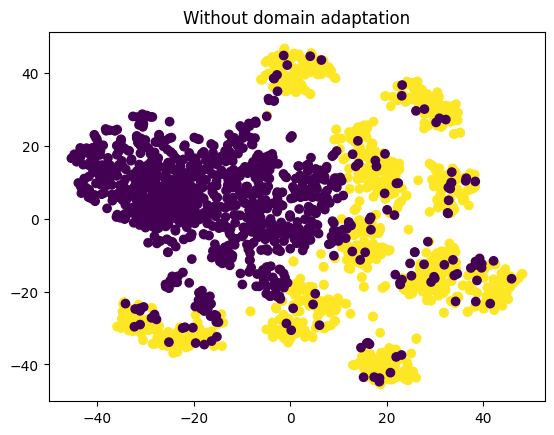

In [32]:
source_emb = extract_emb(naive_net, source_train_loader)
target_emb = extract_emb(naive_net, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("Without domain adaptation")

Yellow dots are the source (MNIST) dataset, while purple dots are the target dataset (MNIST-M). We can clearly see that they belong to different space if we use the naive model.

Original embeddings of source / target (50000, 768) (50000, 768)
Samples embeddings (2000, 768) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

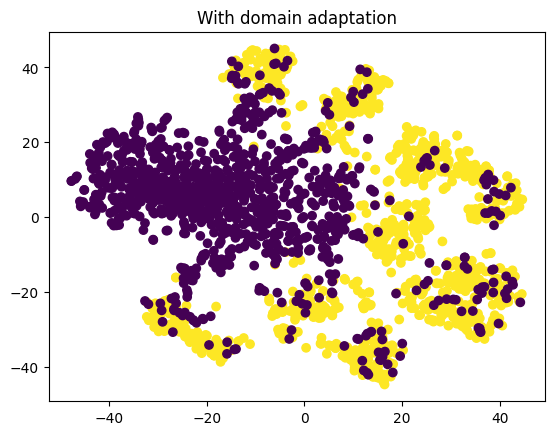

In [33]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

But with our DANN, while still imperfect, the two domains are much more merged. This confirm our intuition that the GRL forces the network to produce domain-agnostic features.

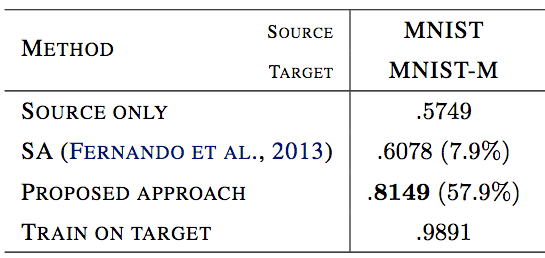

Our model is still lower than the performance reported in the original paper. You can try to further improve it by:

- use much more epochs
- modify the learning rate scheduler to be updated per step
- test different standardization
- different GRL factor scheduling